A lot of product images are actually brand logos, we are going to train a classifier to identify these logo pictures and exclude them from the training set.


#### Define neural network structure

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(3, 8, 5, padding=2)
        self.conv2 = nn.Conv2d(8, 8, 5, padding=2)
        self.conv3 = nn.Conv2d(8, 16, 3, padding=1)
        self.conv4 = nn.Conv2d(16, 16, 3, padding=1)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16*32*32, 64)
        self.fc2 = nn.Linear(64, 16)
        self.fc3 = nn.Linear(16, 1)
        
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, (2, 2))
        
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, (2, 2))
        
        # If the size is a square you can only specify a single number
        x = x.view(-1, self.num_flat_features(x))
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        x = x.view(-1)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


model = Net()
print(model)

Net(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=16384, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
  (dropout): Dropout(p=0.2)
)


#### Training function

In [2]:
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import copy

def train(train_loader, val_loader=None, model=None, epoch=1, optimizer=None, criterion=None):
        
    best_loss = 100
    best_epoch = 0
    best_model_wts = None
    
    for t in range(epoch):
        
        model.train()
        
        for i_batch, batch in enumerate(train_loader):
            
            batch_X, batch_y = batch
            batch_y_pred = model(batch_X)
            loss = criterion(batch_y_pred, batch_y.type(torch.FloatTensor))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if val_loader is not None:
            
            model.eval()
            running_loss = 0.0
            with torch.no_grad():
                for i_batch, batch in enumerate(val_loader):
                    batch_X, batch_y = batch
                    batch_y_pred = model(batch_X)
                    loss = criterion(batch_y_pred, batch_y.type(torch.FloatTensor))                   
                    running_loss += loss.item() * batch_X.size()[0]
        
            epoch_loss = running_loss / len(val_loader.dataset)
            print ("epoch %d, loss %.6f"%(t, epoch_loss))
            
            if epoch_loss < best_loss:
                best_loss = epoch_loss
                best_epoch = t
                best_model_wts = copy.deepcopy(model.state_dict())
                
    if best_model_wts is not None:
        print("load best weights from epoch %d"%best_epoch)
        model.load_state_dict(best_model_wts)

#### Load dataset and Training
We are using a manually labeled small dataset with logo and non-logo pictures.

In [3]:
dataset = ImageFolder("images/filter_training", transform=transforms.ToTensor())
dataloader = DataLoader(dataset, batch_size=32,
                        shuffle=True, num_workers=4)

model = Net()
optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()
train(dataloader, dataloader, model, epoch=20, optimizer=optimizer, criterion=criterion)

epoch 0, loss 0.581963
epoch 1, loss 0.501049
epoch 2, loss 0.443011
epoch 3, loss 0.399390
epoch 4, loss 0.367810
epoch 5, loss 0.461892
epoch 6, loss 0.393165
epoch 7, loss 0.343387
epoch 8, loss 0.332205
epoch 9, loss 0.347846
epoch 10, loss 0.312058
epoch 11, loss 0.316692
epoch 12, loss 0.348420
epoch 13, loss 0.390470
epoch 14, loss 0.313885
epoch 15, loss 0.258308
epoch 16, loss 0.195560
epoch 17, loss 0.194307
epoch 18, loss 0.154710
epoch 19, loss 0.144474
load best weights from epoch 19


#### Define test dataset

In [4]:
from skimage import io
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

class ImagesWithPaths(Dataset):

    def __init__(self, image_paths, transform=None):
        self.paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        path = self.paths[index]
        image = io.imread(path)
        if self.transform:
            image = self.transform(image)
        return image, path
    
    def getitem_bypath(self, path, do_transform=True):
        image = io.imread(path)
        if self.transform and do_transform:
            image = self.transform(image)
        return image        

#### Read all image paths from csv files and load test dataset

In [5]:
cols = ['product_names','brand','price','image_path']
skin_care_df = pd.read_csv("../web_scraper/skin_care_products.csv", usecols=cols)
body_care_df = pd.read_csv("../web_scraper/body_care_products.csv", usecols=cols)
makeup_df = pd.read_csv("../web_scraper/makeup_products.csv", usecols=cols)

# merge skin-care, body-care and makeup table
df = pd.concat([skin_care_df,body_care_df,makeup_df], sort=False).reset_index(drop=True)
image_paths = df['image_path'].dropna().unique()

# instantiate the dataset and dataloader
testset = ImagesWithPaths(image_paths, transform=transforms.ToTensor()) # our custom dataset
testloader = DataLoader(testset, batch_size = 64, shuffle=False)

#### Use trained model to make predictions of test data (all images), save predictions to csv file.

In [6]:
results = pd.DataFrame()

model.eval()
with torch.no_grad():
# iterate over data
    for images, paths in tqdm(testloader):
        preds = model(images)
        results = results.append(pd.DataFrame({'image_path': paths, 'islogo': preds.numpy()}))
        
results = results.set_index('image_path')
df['islogo'] = df['image_path'].map(results['islogo'])
df.to_csv('images.csv', index=False)
df.head()

100%|██████████| 123/123 [03:37<00:00,  1.76s/it]


,product_names,brand,price,image_path,islogo
0,Clear Complexion Spot Treatment,Merle Norman,20.00,images/skin_care/Clear-Complexion-Spot-Treatme...,0.963436
1,Acne Solutions Emergency Gel Lotion,Clinique,17.00,images/skin_care/Acne-Solutions-Emergency-Gel-...,0.011180
2,RESIST Daily Pore-Refining Solution 2% BHA,Paula's Choice Skincare,33.00,images/skin_care/RESIST-Daily-Pore-Refining-So...,0.567055
3,Max Complexion Correction Pads,Peter Thomas Roth,40.00,images/skin_care/Max-Complexion-Correction-Pad...,0.005085
4,Naturals Acne Spot Treatment,Neutrogena,8.49,images/skin_care/Naturals-Acne-Spot-Treatment_...,0.000562


#### prediction distribution

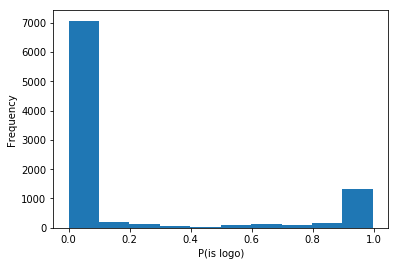

In [7]:
df.islogo.plot.hist()
plt.xlabel("P(is logo)")
plt.show()

#### Sample some predicted logo images...

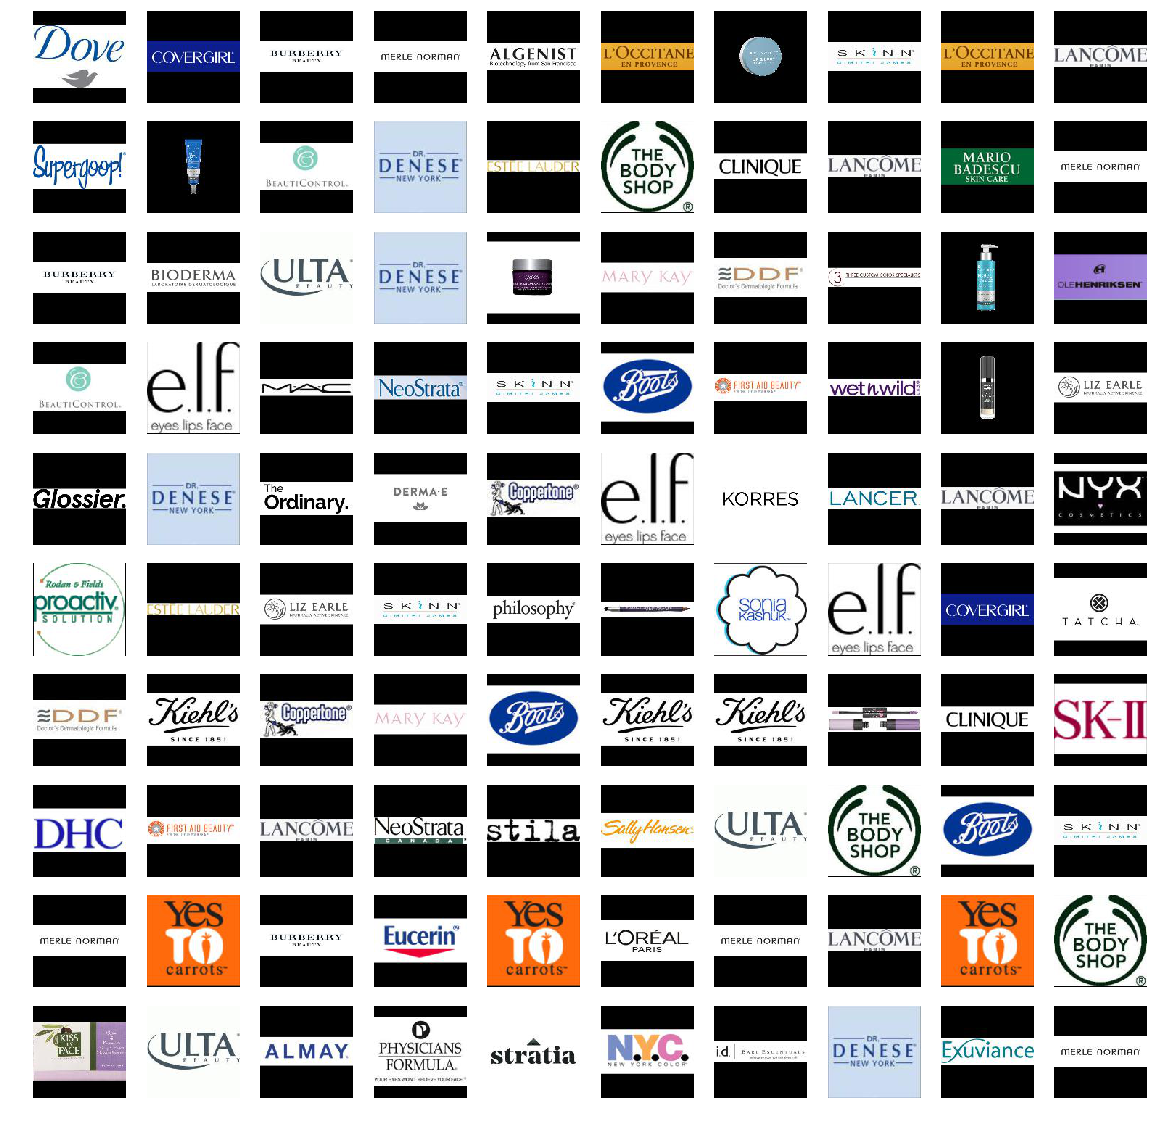

In [4]:
thresh = 0.5
fig, ax = plt.subplots(10,10,figsize=(20,20))
for i, image_path in enumerate(df['image_path'].loc[df['islogo']>thresh].sample(100).values):
    image = io.imread(image_path)
    plt.subplot(10,10,i+1)
    plt.imshow(image)
    plt.axis('off')
plt.show()

#### Sample some predicted non-logo images...

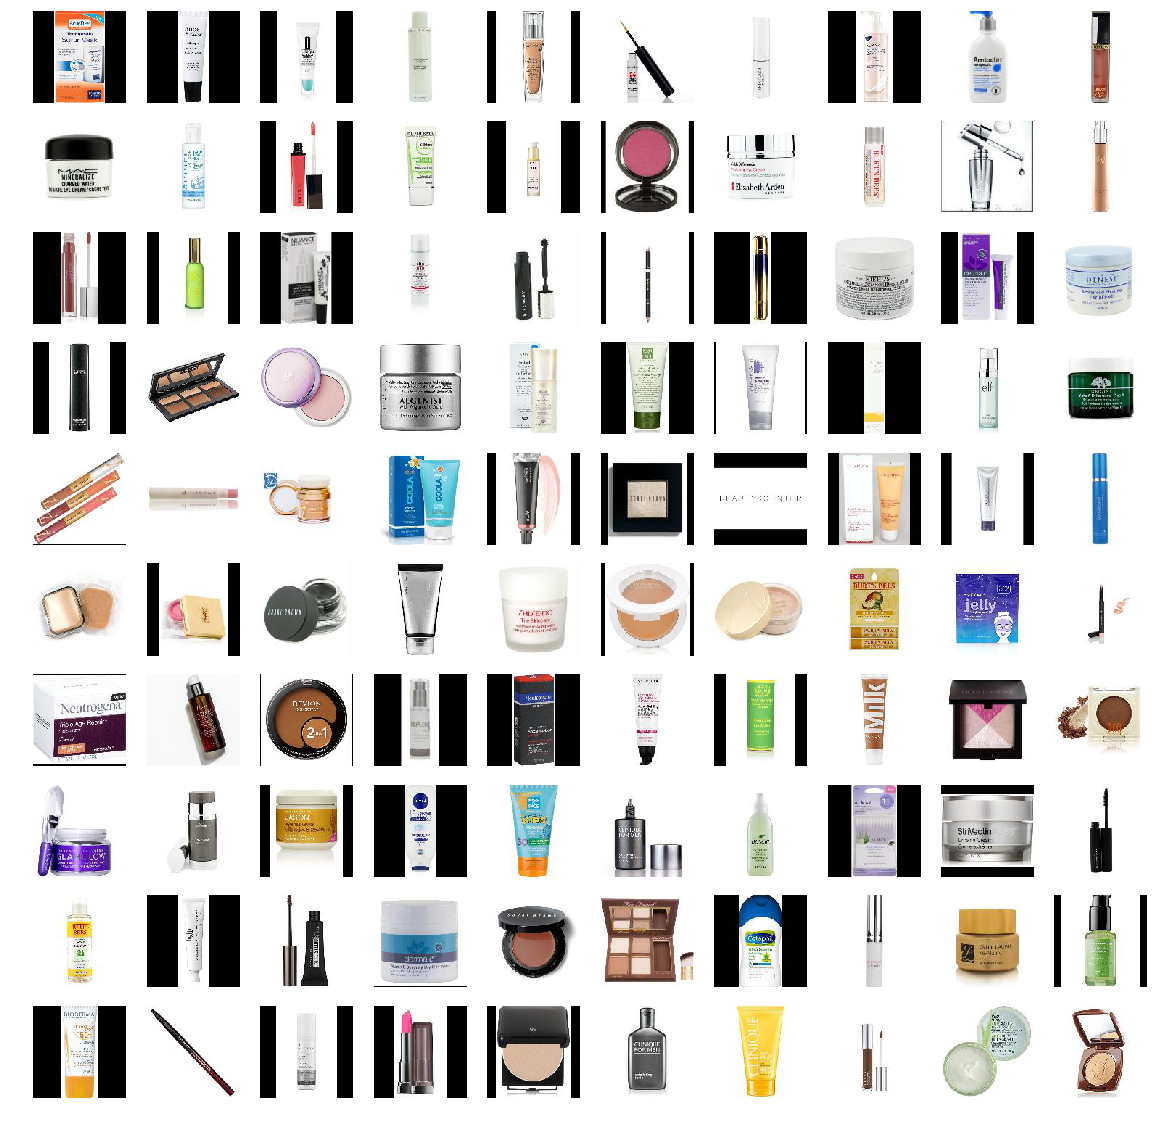

In [5]:
fig, ax = plt.subplots(10,10,figsize=(20,20))
for i, image_path in enumerate(df['image_path'].loc[df['islogo']<thresh].sample(100).values):
    image = io.imread(image_path)
    plt.subplot(10,10,i+1)
    plt.imshow(image)
    plt.axis('off')
plt.show()